# Model building and training

In [1]:
# Importing important libraries and modelues packages
import pandas as pd
import re
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv(r"C:\Users\IQRA SHAIKH\OneDrive\Documents\GitHub\Climate_change_modeling\projects_files\climate_nasa_cleaned.csv")
df.head(3)

,date,likesCount,commentsCount,year,month,weekday,clean_text,sentiment
0,2022-09-07 17:12:32+00:00,2,5.0,2022,9,Wednesday,neat comparison i have not heard it before i...,neutral
1,2022-09-08 14:51:13+00:00,0,5.0,2022,9,Thursday,an excellent way to visualise the invisible t...,positive
2,2022-09-07 17:19:41+00:00,1,3.0,2022,9,Wednesday,does the co ghg in the troposphere affect the...,neutral


In [7]:
# Drop rows with missing or empty clean_text or sentiment
df = df[df['clean_text'].notna() & df['clean_text'].str.strip().ne("")]
df = df[df['sentiment'].notna()]

# Now extract X and y
X = df['clean_text']
y = df['sentiment']

In [3]:
# Feature extraction
X = df['clean_text']
y = df['sentiment']

In [26]:
import re

def clean_text(text):
	if pd.isnull(text):
		return ""
	# Remove non-alphabetic characters and convert to lowercase
	text = re.sub(r'[^a-zA-Z\s]', '', str(text))
	return text.lower().strip()

# Clean and drop bad entries
df['clean_text'] = df['clean_text'].apply(clean_text)
df = df[df['clean_text'].notna()]
df = df[df['clean_text'].str.strip() != ""]

In [27]:
# Redefine X after cleaning to avoid np.nan issues
X = df['clean_text']

vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X_vectorized = vectorizer.fit_transform(X)

In [28]:
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X_vectorized = vectorizer.fit_transform(X)

# Apply SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y)


In [29]:
# Split balanced dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [12]:
# 3. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [13]:
from sklearn.preprocessing import LabelEncoder

# 4. Train, predict, evaluate
# ----------------------------
results = []

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

for name, model in models.items():
    print(f"\n Training {name}...")
    # Use encoded labels for training if required
    if name == "XGBoost":
        model.fit(X_train, y_train_enc)
        y_pred_enc = model.predict(X_test)
        y_pred = le.inverse_transform(y_pred_enc)
        acc = accuracy_score(y_test, y_pred)
        print(f"✅ {name} Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred))
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"✅ {name} Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred))


 Training Logistic Regression...
✅ Logistic Regression Accuracy: 0.8977
              precision    recall  f1-score   support

    negative       1.00      0.98      0.99        58
     neutral       0.86      0.83      0.84        59
    positive       0.84      0.88      0.86        59

    accuracy                           0.90       176
   macro avg       0.90      0.90      0.90       176
weighted avg       0.90      0.90      0.90       176


 Training Naive Bayes...
✅ Naive Bayes Accuracy: 0.8409
              precision    recall  f1-score   support

    negative       0.79      1.00      0.89        58
     neutral       0.94      0.56      0.70        59
    positive       0.84      0.97      0.90        59

    accuracy                           0.84       176
   macro avg       0.86      0.84      0.83       176
weighted avg       0.86      0.84      0.83       176


 Training Random Forest...
✅ Random Forest Accuracy: 0.8636
              precision    recall  f1-score   s

c:\Users\IQRA SHAIKH\OneDrive\Documents\GitHub\Climate_change_modeling\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:35:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Accuracy: 0.8466
              precision    recall  f1-score   support

    negative       0.98      0.91      0.95        58
     neutral       0.75      0.85      0.79        59
    positive       0.84      0.78      0.81        59

    accuracy                           0.85       176
   macro avg       0.85      0.85      0.85       176
weighted avg       0.85      0.85      0.85       176



In [18]:
# Metrics for each model and class
data = {
    'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'XGBoost'],
    'Accuracy': [0.8977, 0.8409, 0.8620, 0.8466],

    'Negative_Precision': [1.00, 0.79, 0.88, 0.98],
    'Negative_Recall':    [0.98, 1.00, 0.91, 0.91],
    'Negative_F1':        [0.99, 0.89, 0.89, 0.95],

    'Neutral_Precision':  [0.86, 0.94, 0.92, 0.75],
    'Neutral_Recall':     [0.83, 0.56, 0.64, 0.85],
    'Neutral_F1':         [0.84, 0.70, 0.75, 0.79],

    'Positive_Precision': [0.84, 0.84, 0.86, 0.84],
    'Positive_Recall':    [0.88, 0.97, 0.93, 0.78],
    'Positive_F1':        [0.86, 0.90, 0.89, 0.81]
}
# Creating the DataFrame
results_df = pd.DataFrame(data)


In [19]:
# Display table
print("\n📊 Model Evaluation Summary:\n")
display(results_df)

# Optional: Save as CSV
results_df.to_csv("model_evaluation_summary.csv", index=False)
print("✅ Evaluation table saved as 'model_evaluation_summary.csv'")


📊 Model Evaluation Summary:



,Model,Accuracy,Negative_Precision,Negative_Recall,Negative_F1,Neutral_Precision,Neutral_Recall,Neutral_F1,Positive_Precision,Positive_Recall,Positive_F1
0,Logistic Regression,0.8977,1.00,0.98,0.99,0.86,0.83,0.84,0.84,0.88,0.86
1,Naive Bayes,0.8409,0.79,1.00,0.89,0.94,0.56,0.70,0.84,0.97,0.90
2,Random Forest,0.8620,0.88,0.91,0.89,0.92,0.64,0.75,0.86,0.93,0.89
3,XGBoost,0.8466,0.98,0.91,0.95,0.75,0.85,0.79,0.84,0.78,0.81


✅ Evaluation table saved as 'model_evaluation_summary.csv'


In [20]:
# 5. Visualize comparison
# ----------------------------
model_names = [r[0] for r in results]
accuracies = [r[1] for r in results]

C:\Users\IQRA SHAIKH\AppData\Local\Temp\ipykernel_37364\397078421.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="viridis")
C:\Users\IQRA SHAIKH\AppData\Local\Temp\ipykernel_37364\397078421.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\IQRA SHAIKH\OneDrive\Documents\GitHub\Climate_change_modeling\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


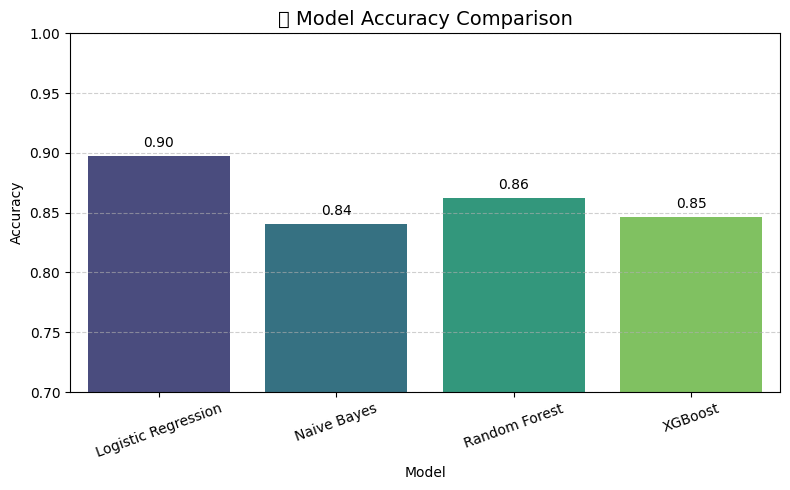

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define model names and accuracy values
model_names = ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'XGBoost']
accuracies = [0.8977, 0.8409, 0.8620, 0.8466]

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette="viridis")

# Add values on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.2f}", ha='center', va='bottom', fontsize=10)

# Customize plot
plt.title("📊 Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=20)
plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show plot
plt.show()


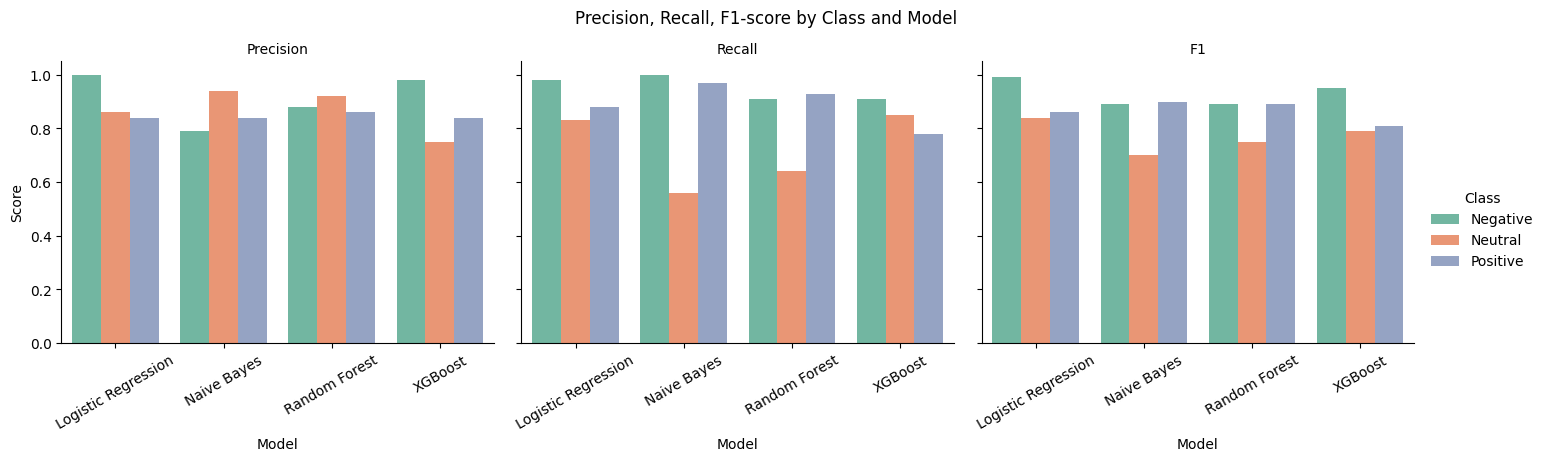

In [31]:
# Melt results_df for plotting
metrics = ['Precision', 'Recall', 'F1']
classes = ['Negative', 'Neutral', 'Positive']

melted_df = pd.DataFrame()
for metric in metrics:
    for cls in classes:
        col_name = f"{cls}_{metric}"
        temp = results_df[['Model', col_name]].copy()
        temp['Class'] = cls
        temp['Metric'] = metric
        temp = temp.rename(columns={col_name: 'Score'})
        melted_df = pd.concat([melted_df, temp], ignore_index=True)

g = sns.catplot(
    data=melted_df,
    kind='bar',
    x='Model',
    y='Score',
    hue='Class',
    col='Metric',
    palette='Set2',
    height=4,
    aspect=1.2
)
g.set_titles("{col_name}")
g.set_xticklabels(rotation=30)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Precision, Recall, F1-score by Class and Model')
plt.show()


In [32]:
# Save best model and vectorizer
logistic_model = models["Logistic Regression"]
joblib.dump(logistic_model, 'best_sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("✅ Best model and vectorizer saved as 'best_sentiment_model.pkl' and 'tfidf_vectorizer.pkl'")


✅ Best model and vectorizer saved as 'best_sentiment_model.pkl' and 'tfidf_vectorizer.pkl'


In [34]:
# Save the best model
import joblib

joblib.dump(logistic_model, 'best_sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("🏆 Best model 'Logistic Regression' saved successfully!")


🏆 Best model 'Logistic Regression' saved successfully!
